Simulated Annealing
=======

# Theory

## Definition


## Examples


# Implementation


## Imports

In [320]:
import numpy as np
import pandas as pd
from typing import Callable
import matplotlib.pyplot as plt

In [321]:
# cost function
cost_func = lambda x : (x-4)**2                     # function to optimize
domain = [-5,25]                                     # expected search domain
x_0 = 2.5                                           # starting value search

# cooling schedule
cooling_func = lambda t : 1000*np.exp(-0.95*t)      # temperature decay function
cooling_window = [0,15]                             # cooling function domain

## Algorithm


In [322]:
def SA(cost_func: Callable, x_0: float, cooling_schedule: tuple[Callable, list], maxiter: int = int(1e3), task: str = "minimization") -> tuple[float, list, int]:
    '''
    _summary_

    Args:
        cost_func: _description_
        x_0: _description_
        cooling_schedule: _description_
        maxiter: _description_. Defaults to int(1e3).
        task: _description_. Defaults to "minimization".

    Returns:
        _description_
    '''
    
    # if task is "minimization"
    cooling_func, cooling_window = cooling_schedule


    # algorithm data
    T = cooling_func( np.linspace(*cooling_window, num=maxiter) )
    cost = [cost_func(x_0)]
    x = [x_0]

    for i in range(maxiter-1):
        
        x_neighbor = x[-1] + np.random.uniform(-1,1)
        delta_cost = cost_func(x_neighbor) - cost_func(x[-1])

        # accept better neighbor
        if delta_cost <= 0:
            x.append(x_neighbor)
            cost.append(cost_func(x_neighbor))

        # energy-driven accept probability for bad neighbor
        elif np.exp(-delta_cost/T[i]) > np.random.uniform(0,1):
            x.append(x_neighbor)
            cost.append(cost_func(x_neighbor))


    return cost, np.array(x), T

## Results Visualization & Basic Convergence Analysis


In [323]:
cost, x, t = SA(cost_func=cost_func, x_0=x_0, cooling_schedule=(cooling_func, cooling_window))

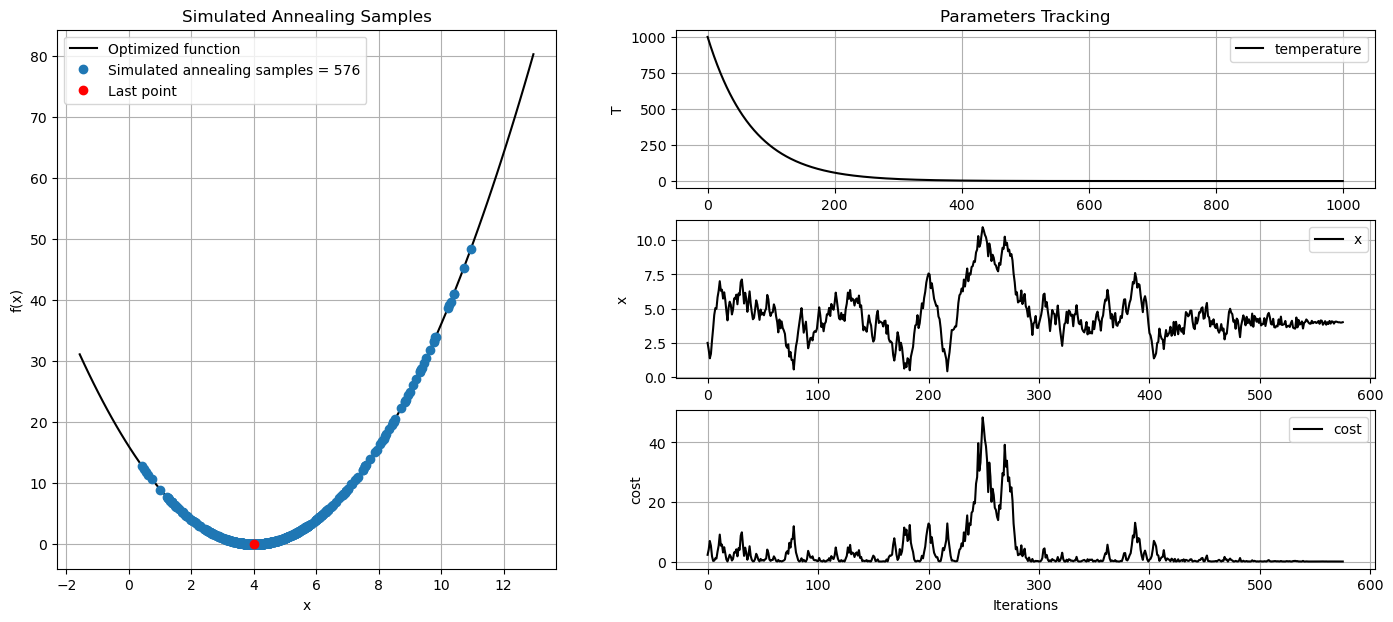

,Property,Value
0,optimal x,4.012356
1,cost at optimal x,0.000153
2,total search samples,1000 samples
3,accepted samples,576 samples
4,rejected samples,424 samples


In [326]:
fig, ax = plt.subplot_mosaic([['upper left', 'upper right'],
                              ['upper left', 'right'],
                              ['upper left', 'lower right']],
                             figsize=(17,7), gridspec_kw={'width_ratios': [1, 1.4]})

xx = np.linspace(np.min(x)-2, np.max(x)+2, num=100)

# gradient decent steps plot
ax['upper left'].plot(xx, cost_func(xx), "k", label="Optimized function")
ax['upper left'].plot(x, cost_func(x), "o", label=f"Simulated annealing samples = {len(x)}")
ax['upper left'].plot(x[-1], cost_func(x[-1]), "ro", label="Last point")
ax['upper left'].set(xlabel="x", ylabel="f(x)", title="Simulated Annealing Samples")
ax['upper left'].grid(True)
ax['upper left'].legend()

# temperature value tracking
ax['upper right'].plot(range(len(t)), t, "k", label="temperature")
ax['upper right'].set(ylabel="T", title="Parameters Tracking")
ax['upper right'].grid(True)
ax['upper right'].legend()


# x value tracking
ax['right'].plot(range(len(x)), x, "k", label="x")
ax['right'].set(ylabel="x")
ax['right'].grid(True)
ax['right'].legend()

# cost value tracking
ax['lower right'].plot(range(len(cost)), cost, "k", label="cost")
ax['lower right'].set(xlabel="Iterations", ylabel="cost")
ax['lower right'].grid(True)
ax['lower right'].legend()


# summary
summary = [
    ("optimal x", x[-1]),
    ("cost at optimal x", cost[-1]),
    ("total search samples", f"{len(t)} samples"),
    ("accepted samples", f"{len(x)} samples"),
    ("rejected samples", f"{len(t) - len(x)} samples")
    ]

df = pd.DataFrame(data=summary, columns=["Property", "Value"])

plt.show()
df